## First try at getting some data

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
#Essentials
import numpy as np
import pandas as pd
import pickle
import re

#API imports
from sodapy import Socrata

#SQL related
import psycopg2
import sqlite3
from sqlalchemy import create_engine
import pandas.io.sql as pd_sql

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import shapely
from shapely.geometry import Point
# import contextily as ctx

#Regression imports
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn import feature_selection as f_select
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import learning_curve

from sklearn.pipeline import make_pipeline

%matplotlib inline

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Load all the data into an SQL database

In [3]:
# Set up the database connection
conn = psycopg2.connect(dbname="taxi_rides_db", user="auste_m")

In [4]:
# CREATE TABLE taxi_rides_clean (
#                             trip_id TEXT, 
#                             taxi_id TEXT, 
#                             trip_start_timestamp TIMESTAMP,
#                             trip_end_timestamp TIMESTAMP,
#                             trip_seconds INT,
#                             trip_miles FLOAT,
#                             pickup_census_tract TEXT,
#                             pickup_community_area TEXT,
#                             dropoff_census_tract TEXT,
#                             dropoff_community_area TEXT,
#                             fare FLOAT,
#                             tips FLOAT,
#                             tolls FLOAT,
#                             extras FLOAT,
#                             trip_total FLOAT,
#                             payment_type TEXT,
#                             company TEXT,
#                             pickup_centroid_latitude FLOAT,
#                             pickup_centroid_longitude FLOAT,
#                             pickup_centroid_location TEXT,
#                             dropoff_centroid_latitude FLOAT,
#                             dropoff_centroid_longitude FLOAT,
#                             dropoff_centroid_location TEXT
#                         );

In [5]:
# COPY taxi_rides from '/home/ubuntu/Passion_Project/Taxi_Trips.csv' DELIMITER ',' CSV HEADER;
# COPY taxi_rides from '/home/ubuntu/Passion_Project/Taxi_Trips_2016.csv' DELIMITER ',' CSV HEADER;

In [6]:
# CREATE TABLE chicago_weather(
#                                 station TEXT,
#                                 name TEXT, 
#                                 latitude FLOAT,
#                                 longitude FLOAT,
#                                 elevation FLOAT,
#                                 date TIMESTAMP, 
#                                 avg_daily_wind_speed FLOAT,
#                                 peak_gust_time FLOAT,
#                                 precipitation_mm FLOAT,
#                                 snowfall_mm FLOAT,
#                                 snowdepth_mm FLOAT,
#                                 avg_temp_f INT,
#                                 fog INT,
#                                 heavy_fog INT,
#                                 thunder INT,
#                                 sleet INT,
#                                 hail INT, 
#                                 glaze INT,
#                                 smoke INT,
#                                 drifting_snow INT, 
#                                 mist INT,
#                                 drizzle INT,
#                                 rain INT,
#                                 freezing_rain INT,
#                                 snow INT,
#                                 unkwn_precipitation INT,
#                                 ice_fog INT
#                                  );

In [7]:
# COPY chicago_weather FROM '/home/ubuntu/Chicago_Historical_Weather_Dataset.csv' DELIMITER ',' CSV HEADER;

In [8]:
taxi_rides_query = """SELECT * FROM taxi_rides WHERE trip_start_timestamp BETWEEN '2016-02-01' AND '2016-02-15';""" 
weather_query = """SELECT * FROM chicago_weather WHERE date BETWEEN '2016-02-01' AND '2016-02-15';"""

taxi_weather_query = """SELECT TR.trip_start_timestamp,
                                TR.trip_end_timestamp,
                                TR.trip_seconds,
                                TR.trip_miles,
                                --TR.pickup_community_area,
                                --TR.dropoff_community_area,
                                TR.fare,
                                TR.tolls,
                                TR.tips,
                                TR.trip_total,
                                TR.payment_type,
                                TR.pickup_centroid_latitude,
                                TR.pickup_centroid_longitude,
                                TR.pickup_centroid_location,
                                TR.dropoff_centroid_latitude,
                                TR.dropoff_centroid_longitude,
                                TR.dropoff_centroid_location,
                                CW.avg_daily_wind_speed,
                                CW.avg_temp_f,
                                CASE WHEN CW.fog = 1 OR CW.heavy_fog = 1 OR ice_fog = 1 OR mist = 1 THEN 1 ELSE 0 END as fog,
                                CASE WHEN CW.rain = 1 OR CW.drizzle = 1 OR CW.hail = 1 THEN 1 ELSE 0 END as rain,
                                CASE WHEN CW.snow = 1 OR CW.freezing_rain = 1 OR drifting_snow = 1 THEN 1 ELSE 0 END as snow
                                
                        FROM taxi_rides_clean as TR
                        LEFT JOIN chicago_weather as CW
                        ON CAST(TR.trip_start_timestamp AS DATE) = CAST(date AS DATE)
                        WHERE trip_start_timestamp BETWEEN '2016-02-01' AND '2016-02-15';""" 

In [9]:
#Read in Chicago city community area shapefile
# chicago_community_areas = gpd.read_file("./datasets/Chicago_Community_Areas/geo_export_4c20eda0-2d92-4a1d-8513-878eb3e095a3.shp")

In [10]:
#approx. 30min to load the whole of 2016 data
sql_load = pd.read_sql_query(taxi_weather_query, con=conn)

In [11]:
taxi_weather_df = sql_load

In [12]:
taxi_weather_df.head()

,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,fare,tolls,tips,trip_total,payment_type,pickup_centroid_latitude,pickup_centroid_longitude,pickup_centroid_location,dropoff_centroid_latitude,dropoff_centroid_longitude,dropoff_centroid_location,avg_daily_wind_speed,avg_temp_f,fog,rain,snow
0,2016-02-01 22:30:00,2016-02-01 23:00:00,1380.0,13.7,35.00,0.0,7.80,46.80,Credit Card,41.792592,-87.769615,POINT (-87.7696154528 41.7925923603),41.794090,-87.592311,POINT (-87.592310855 41.794090253),4.92,36,1,0,0
1,2016-02-01 00:45:00,2016-02-01 01:00:00,1140.0,0.3,18.50,0.0,0.00,21.00,Cash,41.944227,-87.655998,POINT (-87.6559981815 41.9442266014),41.874005,-87.663518,POINT (-87.6635175498 41.874005383),4.92,36,1,0,0
2,2016-02-01 14:00:00,2016-02-01 14:00:00,840.0,2.5,10.50,0.0,2.00,12.50,Credit Card,41.870607,-87.622173,POINT (-87.6221729369 41.8706073724),41.885281,-87.657233,POINT (-87.6572331997 41.8852813201),4.92,36,1,0,0
3,2016-02-01 19:00:00,2016-02-01 19:30:00,1080.0,4.3,14.75,0.0,2.95,17.70,Credit Card,41.878866,-87.625192,POINT (-87.6251921424 41.8788655841),41.922761,-87.699155,POINT (-87.6991553432 41.9227606205),4.92,36,1,0,0
4,2016-02-01 08:30:00,2016-02-01 08:45:00,480.0,4.8,14.00,0.0,4.75,23.75,Credit Card,41.980264,-87.913625,POINT (-87.913624596 41.9802643146),41.980264,-87.913625,POINT (-87.913624596 41.9802643146),4.92,36,1,0,0


> Original number of records for 1st-15th February 2016: **831,790**

In [13]:
#Let's explore the dataset
null_records = taxi_weather_df[(taxi_weather_df['pickup_centroid_latitude'].isnull()) | (taxi_weather_df['pickup_centroid_longitude'].isnull()) | 
                (taxi_weather_df['dropoff_centroid_latitude'].isnull()) | (taxi_weather_df['dropoff_centroid_longitude'].isnull()) | 
                (taxi_weather_df['trip_seconds'].isnull()) | (taxi_weather_df['trip_miles'].isnull()) | 
                (taxi_weather_df['fare'].isnull())]['trip_start_timestamp'].count()

print(f'There are {null_records} records with a null value in at least one of the fields mentioned above.')

There are 158316 records with a null value in at least one of the fields mentioned above.


## Sweeping time!

In [14]:
#Change payment type to boolean
taxi_weather_df['payment_type'] = pd.Categorical(taxi_weather_df['payment_type'])

In [15]:
#Let's drop all the records with a missing lat / long in either pickup or dropoff
taxi_weather_df.dropna(subset=['pickup_centroid_latitude', 'pickup_centroid_longitude', 'dropoff_centroid_latitude', 'dropoff_centroid_longitude',
                              'trip_seconds', 'trip_miles', 'fare'], inplace=True)

In [16]:
taxi_weather_df.count()[0]

673474

> Remaining number of records after removing missing values containing records for 1st-15th February 2016: **81%** (673,474)

In [17]:
#Check how many records where removed by taking out zero value rows for fare, trip_seconds and trip_miles #139,699
# taxi_weather_df[(taxi_weather_df['fare'] == 0.0) 
#                                           | (taxi_weather_df['trip_seconds'] == 0.0) 
#                                           | (taxi_weather_df['trip_miles'] == 0.0)].count()

In [18]:
#Let's get rid of the zeroes
taxi_weather_df = taxi_weather_df[(taxi_weather_df['fare'] != 0.0) 
                                          & (taxi_weather_df['trip_seconds'] != 0.0) 
                                          & (taxi_weather_df['trip_miles'] != 0.0)]

In [19]:
taxi_weather_df.count()[0]

533775

> Remaining number of records after null and zero value removal for 1st-15th February 2016: **64%** (533,775)

In [20]:
#Since taxi fare doesn't automatically include tolls, to get a base rate, I need to add tolls to the fare
taxi_weather_df['fare_with_tolls'] = taxi_weather_df['fare'] + taxi_weather_df['tolls']

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [21]:
#Removing clear error records from the dataset (e.g. $1,000 for 0.1 mile and 6 min ride)
taxi_weather_df[(taxi_weather_df['fare_with_tolls'] >= 50.0) & (taxi_weather_df['trip_miles'] <= 5.0) & 
                (taxi_weather_df['trip_seconds'] <= 600.0)]

,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,fare,tolls,tips,trip_total,payment_type,pickup_centroid_latitude,...,pickup_centroid_location,dropoff_centroid_latitude,dropoff_centroid_longitude,dropoff_centroid_location,avg_daily_wind_speed,avg_temp_f,fog,rain,snow,fare_with_tolls
83189,2016-02-02 08:45:00,2016-02-02 09:00:00,600.0,0.30,478.58,0.0,0.0,478.58,Cash,41.965812,...,POINT (-87.6558787862 41.96581197),41.965812,-87.655879,POINT (-87.6558787862 41.96581197),11.41,35,1,0,0,478.58
163387,2016-02-03 06:00:00,2016-02-03 06:00:00,60.0,0.30,65.00,0.0,0.0,65.00,Credit Card,41.985015,...,POINT (-87.8045320063 41.9850151008),41.980264,-87.913625,POINT (-87.913624596 41.9802643146),13.42,36,1,0,0,65.00
248731,2016-02-05 17:00:00,2016-02-05 17:15:00,540.0,0.80,773.77,0.0,0.0,773.77,Cash,41.968069,...,POINT (-87.7215590627 41.968069),41.968069,-87.721559,POINT (-87.7215590627 41.968069),6.71,29,0,0,0,773.77
301346,2016-02-06 23:45:00,2016-02-07 00:00:00,600.0,2.80,56.50,0.0,0.0,57.50,Cash,41.898306,...,POINT (-87.6536139825 41.8983058696),41.928967,-87.656157,POINT (-87.6561568309 41.9289672664),8.50,31,1,0,0,56.50
369869,2016-02-07 01:00:00,2016-02-07 01:15:00,360.0,0.10,1000.65,0.0,0.0,1000.65,Cash,41.892042,...,POINT (-87.6318639497 41.8920421365),41.871016,-87.631407,POINT (-87.6314065252 41.8710158803),12.97,38,0,0,0,1000.65
414934,2016-02-08 14:00:00,2016-02-08 14:15:00,420.0,0.30,7001.17,50.0,0.0,7051.97,Cash,41.898332,...,POINT (-87.6207628651 41.8983317935),41.943155,-87.640698,POINT (-87.640698076 41.9431550855),11.18,31,1,0,0,7051.17
572899,2016-02-11 21:00:00,2016-02-11 21:00:00,180.0,1.90,77.50,0.0,0.0,83.50,Cash,41.792592,...,POINT (-87.7696154528 41.7925923603),41.792592,-87.769615,POINT (-87.7696154528 41.7925923603),7.16,13,0,0,0,77.50
575164,2016-02-11 20:00:00,2016-02-11 20:15:00,360.0,0.30,91.00,0.0,0.0,91.00,Cash,41.792592,...,POINT (-87.7696154528 41.7925923603),41.792592,-87.769615,POINT (-87.7696154528 41.7925923603),7.16,13,0,0,0,91.00
623525,2016-02-11 17:00:00,2016-02-11 17:00:00,420.0,0.90,455.85,0.0,0.0,455.85,Cash,41.968069,...,POINT (-87.7215590627 41.968069),41.968069,-87.721559,POINT (-87.7215590627 41.968069),7.16,13,0,0,0,455.85
631077,2016-02-12 20:00:00,2016-02-12 20:15:00,480.0,2.45,58.75,0.0,0.0,58.75,Cash,41.934659,...,POINT (-87.6467297286 41.9346591566),41.934659,-87.646730,POINT (-87.6467297286 41.9346591566),17.00,19,0,0,0,58.75


In [34]:
list(fare_per_mile[fare_per_mile > 5000].index)

[369869, 414934]

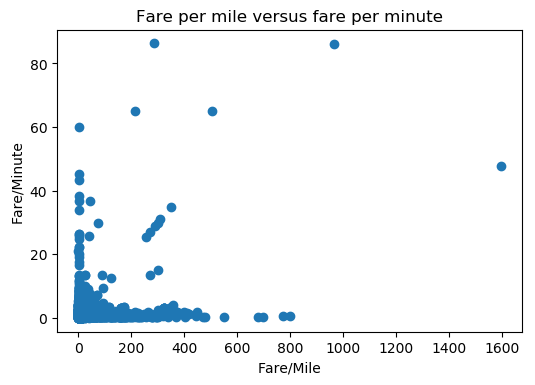

In [36]:
#Let's see that's the distribution of $/mile to better identify incorrect values
fare_per_mile = taxi_weather_df['fare_with_tolls'] / taxi_weather_df['trip_miles']
fare_per_minute = taxi_weather_df['fare_with_tolls'] / (taxi_weather_df['trip_seconds'] / 60)

#Removing obvious outliers
outlier_indices = list((fare_per_mile[fare_per_mile > 5000]).index)
fare_per_mile = fare_per_mile.drop(index=outlier_indices)
fare_per_minute = fare_per_minute.drop(index=outlier_indices)


plt.figure(dpi=100)
plt.scatter(fare_per_mile, fare_per_minute)

#fare_per_mile_per_minute.hist(bins=10000)
# plt.xlim(xmin=0.0, xmax=100.0)
plt.title('Fare per mile versus fare per minute')
plt.xlabel('Fare/Mile')
plt.ylabel('Fare/Minute');

In [38]:
FM20_40 = fare_per_minute[(fare_per_minute >= 20.0) & (fare_per_minute <= 40.0)]
list_of_indices = FM20_40.index.tolist()

#Now get all the corresponding records in the fare / mile series
fm200_400 = fare_per_mile.filter(list_of_indices, axis=0)

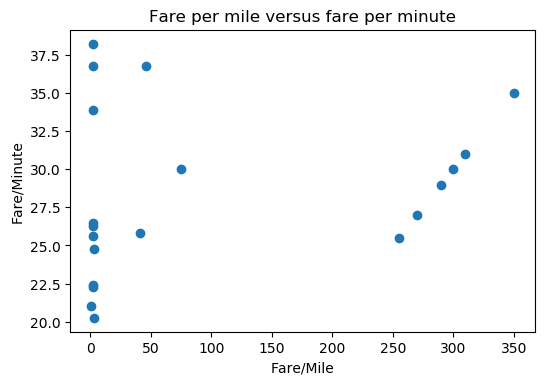

In [39]:
#Zooming in on some strange patterns
plt.figure(dpi=100)
plt.scatter(fm200_400, FM20_40)

#fare_per_mile_per_minute.hist(bins=10000)
# plt.xlim(xmin=0.0, xmax=100.0)
plt.title('Fare per mile versus fare per minute')
plt.xlabel('Fare/Mile')
plt.ylabel('Fare/Minute');

In [46]:
#Let's have a look if the miles per minute look reasonable
miles_per_minute = taxi_weather_df['trip_miles'] / (taxi_weather_df['trip_seconds'] / 3600.0)

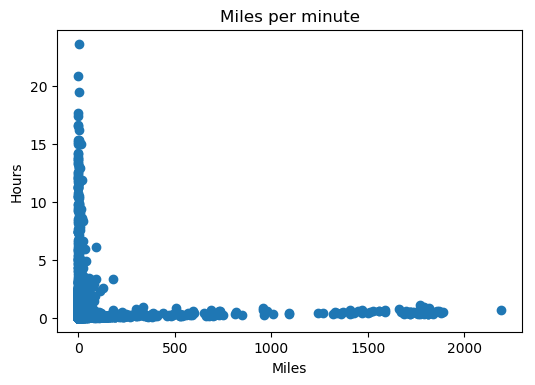

In [47]:
plt.figure(dpi=100)
plt.scatter(taxi_weather_df['trip_miles'], taxi_weather_df['trip_seconds'] / 3600.0)
plt.title('Miles per minute')
plt.xlabel('Miles')
plt.ylabel('Hours');

In [48]:
taxi_weather_df[taxi_weather_df['trip_miles'] >= 100].count()

trip_start_timestamp          382
trip_end_timestamp            382
trip_seconds                  382
trip_miles                    382
fare                          382
tolls                         382
tips                          382
trip_total                    382
payment_type                  382
pickup_centroid_latitude      382
pickup_centroid_longitude     382
pickup_centroid_location      382
dropoff_centroid_latitude     382
dropoff_centroid_longitude    382
dropoff_centroid_location     382
avg_daily_wind_speed          382
avg_temp_f                    382
fog                           382
rain                          382
snow                          382
fare_with_tolls               382
dtype: int64

In [ ]:
#Fare analysis
taxi_weather_df['fare'].hist(bins=10000)
plt.xlim(xmin=0, xmax=100)
plt.title('The distribution of the fare variable')
plt.xlabel('Fare ($)')
plt.ylabel('Frequency');


In [37]:
taxi_weather_df[taxi_weather_df['fare'] > 150.0].groupby(['trip_miles'])['fare'].mean()

trip_miles
0.10      1000.650
0.30      3739.875
0.80       773.770
0.90       455.850
2.30       164.000
2.70       150.250
2.80       165.000
3.20       220.750
3.60       167.000
4.00       151.250
4.50       204.500
10.10      176.000
17.96      153.500
22.80      165.000
24.50      199.250
42.60      159.500
55.70      178.750
58.70      159.250
63.40      155.500
66.80      176.250
67.80      178.750
70.60      164.500
70.93      191.250
71.60      172.250
74.30      175.000
75.30      208.500
81.60      189.250
82.40      211.250
84.70      199.250
91.40      234.250
92.00      255.750
130.00     299.250
181.30     419.750
Name: fare, dtype: float64

In [ ]:
#Let's explore the tips and tolls columns
taxi_weather_df.groupby(['payment_type'])['trip_miles'].describe()

> On average, trips paid with a credit card had longer distance, and therefore, longer duration and higher fare.
> 

In [ ]:
# taxi_weather_gdf[taxi_weather_gdf['dropoff_centroid_longitude'].isnull()].info()

In [ ]:
#Let's explore the distribution of variables of interest
plt.figure(figsize=(30, 20))
plt.rcParams.update({'font.size': 22})

plt.subplot(2, 2, 1)
plt.hist(taxi_weather_df['trip_seconds'], bins=1000, color='c')
plt.title('Trip Length Histogram (in seconds)')
plt.xlim(xmin=0, xmax=10000)
plt.xlabel('Seconds')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
plt.hist(taxi_weather_df['trip_miles'], bins=10000, color='m')
plt.title('Trip Length Histogram (in miles)')
plt.xlim(xmin=0, xmax=30)
plt.xlabel('Miles')
plt.ylabel('Frequency')

plt.subplot(2, 2, 3)
plt.hist(taxi_weather_df['fare'], bins=10000, color='r')
plt.title('Trip Fare (in $)')
plt.xlim(xmin=0, xmax=100)
plt.xlabel('$')
plt.ylabel('Frequency');

plt.subplot(2, 2, 4)
plt.hist(taxi_weather_df['trip_total'].dropna(), bins=10000, color='b')
plt.title('Trip Total Fare (in $)')
plt.xlim(xmin=0, xmax=100)
plt.xlabel('$')
plt.ylabel('Frequency');

### Update location columns for pickup and dropoff using shapely (converting the dataframe to GeoPandas)

In [ ]:
#replace pickup_centroid_location and dropoff_centroid_location columns with point coordinates using shapely
pickup_geopoint = list(zip(taxi_weather_df['pickup_centroid_longitude'], taxi_weather_df['pickup_centroid_latitude']))
dropoff_geopoint = list(zip(taxi_weather_df['dropoff_centroid_longitude'], taxi_weather_df['dropoff_centroid_latitude']))

taxi_weather_df['pickup_centroid_location'] = pickup_geopoint
taxi_weather_df['dropoff_centroid_location'] = dropoff_geopoint

taxi_weather_df['pickup_centroid_location'] = taxi_weather_df['pickup_centroid_location'].apply(Point)
taxi_weather_df['dropoff_centroid_location'] = taxi_weather_df['dropoff_centroid_location'].apply(Point)


In [ ]:
taxi_weather_df.head()

In [ ]:
taxi_weather_gdf = gpd.GeoDataFrame(taxi_weather_df, geometry='pickup_centroid_location')

In [ ]:
taxi_weather_gdf.tail()

In [ ]:
# df = geopandas.read_file(geopandas.datasets.get_path('nybb'))
# world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# # We restrict to North America.
# ax = world[world.continent == 'North America'].plot(
#     color='white', edgecolor='blue')

# # We can now plot our GeoDataFrame.
# taxi_weather_gdf.plot(ax=ax, color='red')
# plt.show()

taxi_weather_gdf.plot(figsize=(10, 10), alpha=0.5, edgecolor='m')
plt.title('Pickup locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude');